In [1]:
import pandas as pd
import numpy as np
import string
import nltk
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
nltk.download('punkt')
nltk.download('stopwords')
nltk.download("wordnet", "/usr/share/nltk_data/")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data/...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
cd /usr/share/nltk_data/corpora/

/usr/share/nltk_data/corpora


In [3]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip 

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: wordnet/
  inflating: wordnet/lexnames        
  inflating: wordnet/data.verb       
  inflating: wordnet/index.adv       
  inflating: wordnet/adv.exc         
  inflating: wordnet/index.verb      
  inflating: wordnet/cntlist.rev     
  inflating: wordnet/data.adj        
  inflating: wordnet/index.adj       
  inflating: wordnet/LICENSE         
  inflating: wordnet/citation.bib    
  inflating: wordnet/noun.exc        
  inflating: wordnet/verb.exc        
  inflating: wordnet/README          
  inflating: wordnet/index.sense     
  inflating: wordnet/data.noun       
  inflating: wordnet/data.adv        
  inflating: wordnet/index.noun      
  inflating: wordnet/adj.exc         


In [4]:
!ls

abc			 kimmo			sentence_polarity
abc.zip			 kimmo.zip		sentence_polarity.zip
alpino			 knbc.zip		sentiwordnet
alpino.zip		 lin_thesaurus		sentiwordnet.zip
biocreative_ppi		 lin_thesaurus.zip	shakespeare
biocreative_ppi.zip	 mac_morpho		shakespeare.zip
brown			 mac_morpho.zip		sinica_treebank
brown.zip		 machado.zip		sinica_treebank.zip
brown_tei		 masc_tagged.zip	smultron
brown_tei.zip		 movie_reviews		smultron.zip
cess_cat		 movie_reviews.zip	state_union
cess_cat.zip		 mte_teip5		state_union.zip
cess_esp		 mte_teip5.zip		stopwords
cess_esp.zip		 names			stopwords.zip
chat80			 names.zip		subjectivity
chat80.zip		 nps_chat		subjectivity.zip
city_database		 nps_chat.zip		swadesh
city_database.zip	 omw.zip		swadesh.zip
cmudict			 opinion_lexicon	switchboard
cmudict.zip		 opinion_lexicon.zip	switchboard.zip
comtrans.zip		 paradigms		timit
conll2000		 paradigms.zip		timit.zip
conll2000.zip		 pil			toolbox
conll2002		 pil.zip		toolbox.zip
conll2002.zip		 pl196x			treebank
conll2007.zip		 pl

In [5]:
cd /kaggle/working/

/kaggle/working


In [6]:
dict1 = {"texts": [], "label": []}
for file in ["Sentences_50Agree.txt", "Sentences_66Agree.txt", "Sentences_75Agree.txt"]:
    with open('/kaggle/input/finacial-pharse-bank/'+file, 'r',encoding='latin-1') as file:
        for line in file:
            sample = line.strip().split("@")
            dict1["texts"].append(sample[0])
            dict1["label"].append(sample[1])
            
df = pd.DataFrame(dict1)

In [7]:
df

,texts,label
0,"According to Gran , the company has no plans t...",neutral
1,Technopolis plans to develop in stages an area...,neutral
2,The international electronic industry company ...,negative
3,With the new production plant the company woul...,positive
4,According to the company 's updated strategy f...,positive
...,...,...
12511,Operating result for the 12-month period decre...,negative
12512,HELSINKI Thomson Financial - Shares in Cargote...,negative
12513,LONDON MarketWatch -- Share prices ended lower...,negative
12514,Operating profit fell to EUR 35.4 mn from EUR ...,negative


In [8]:
print(df.isna().sum())

texts    0
label    0
dtype: int64


In [9]:
df.drop_duplicates(inplace=True)
len(df)

4840

In [10]:
df['label'].value_counts()

label
neutral     2873
positive    1363
negative     604
Name: count, dtype: int64

In [11]:
# Function to clean text
def clean_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Convert text to lowercase
    text = text.lower()
    # Tokenize text
    words = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    # Join words back into a single string
    return ' '.join(words)

In [12]:
# Apply text cleaning function to the 'texts' column
df['texts'] = df['texts'].apply(clean_text)

In [13]:
df.drop_duplicates(inplace=True)
len(df)

4828

In [14]:
df['label'].value_counts()

label
neutral     2861
positive    1363
negative     604
Name: count, dtype: int64

In [15]:
df['label'] = df['label'].map({'negative': 0, 'neutral': 1, 'positive': 2})

In [16]:
from datasets import Dataset

# Convert DataFrame to Hugging Face Dataset
dataset = Dataset.from_pandas(df[['texts', 'label']])

In [17]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding

# Define the model checkpoint and load the tokenizer
model_name = 'sentence-transformers/all-MiniLM-L6-v2'
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenize the input data
def tokenize_function(examples):
    return tokenizer(examples['texts'], padding=True, truncation=True, return_tensors="pt")

# Apply tokenization
dataset = dataset.map(tokenize_function, batched=True)

train_test_split = dataset.train_test_split(test_size=0.2)
train_dataset = train_test_split['train']
eval_dataset = train_test_split['test']


# Create a data collator that pads the input sequences
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Load the model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)


2024-08-02 19:07:56.851184: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-02 19:07:56.851289: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-02 19:07:57.038318: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/4828 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/all-MiniLM-L6-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
train_dataset.remove_columns(["texts"])
eval_dataset.remove_columns(["texts"])

Dataset({
    features: ['label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 966
})

In [19]:
class FinancialSentimentLoss(nn.Module):
    def __init__(self):
        super(FinancialSentimentLoss, self).__init__()
        self.loss_matrix = {
            ('positive', 'negative'): 50,
            ('negative', 'positive'): 50,
            ('neutral', 'negative'): 30,
            ('neutral', 'positive'): 20,
            ('positive', 'neutral'): 5,
            ('negative', 'neutral'): 5,
            ('positive', 'positive'): -20,
            ('negative', 'negative'): -20,
            ('neutral', 'neutral'): -20
        }
    
    def forward(self, predictions, targets):
        sentiment_labels = ['negative', 'neutral', 'positive']
        batch_size = predictions.size(0)
        total_loss = 0.0
        for i in range(batch_size):
            pred_label = sentiment_labels[torch.argmax(predictions[i]).item()]
            target_label = sentiment_labels[targets[i].item()]
            total_loss += self.loss_matrix[(pred_label, target_label)]
        # Ensure loss is a tensor
        return torch.tensor(total_loss / batch_size, dtype=torch.float32)
    
loss_func = FinancialSentimentLoss()

In [20]:
# Define compute_metrics function
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    loss = loss_func(torch.tensor(preds), torch.tensor(labels) )
    cm = confusion_matrix(labels, preds, labels=[0, 1, 2])
    acc1 = (cm[0][0]+cm[1][1]+cm[2][2])/(cm[0][0]+cm[1][1]+cm[2][2]  + cm[0][2]+cm[2][0]+ cm[0][1]+cm[2][1]) 
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'financialloss': loss,
        'acc1': acc1
        
    }


In [21]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=50,
    weight_decay=0.01,
    metric_for_best_model='acc1',
    greater_is_better=True 
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [22]:
import wandb
wandb.login(key="2f4ed7573e0672eacd8131b0b253763170a88072")
wandb.init(project='finacial-pharse-bank-1')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: giriprasad51001 (giriprasad51001-nit-patna). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.4
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240802_190819-cdz0kc2a
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run robust-plasma-19
wandb: ⭐️ View project at https://wandb.ai/giriprasad51001-nit-patna/finacial-pharse-bank-1
wandb: 🚀 View run at https://wandb.ai/giriprasad51001-nit-patna/finacial-pharse-bank-1/runs/cdz0

In [23]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Financialloss,Acc1
1,No log,0.654434,0.748447,0.688184,0.699390,0.689778,14.001035,0.821591
2,No log,0.518310,0.789855,0.745441,0.749109,0.746763,14.001035,0.863122
3,0.687500,0.531460,0.795031,0.749073,0.760476,0.754385,14.001035,0.873720
4,0.687500,0.569268,0.788820,0.743301,0.764233,0.752966,14.001035,0.876870
5,0.374800,0.685288,0.778468,0.722365,0.779282,0.744046,14.001035,0.890995
6,0.374800,0.751981,0.793996,0.747657,0.771235,0.758324,14.001035,0.887731
7,0.217500,0.849840,0.781573,0.729268,0.758070,0.742065,14.001035,0.874855
8,0.217500,0.915814,0.782609,0.726450,0.767284,0.743331,14.001035,0.879070
9,0.148500,1.034743,0.774327,0.727029,0.740972,0.732529,14.001035,0.873832
10,0.148500,1.086308,0.785714,0.731169,0.777685,0.749694,14.001035,0.881533


TrainOutput(global_step=12100, training_loss=0.08188795286269228, metrics={'train_runtime': 580.1971, 'train_samples_per_second': 332.818, 'train_steps_per_second': 20.855, 'total_flos': 1363743031997736.0, 'train_loss': 0.08188795286269228, 'epoch': 50.0})

In [24]:
# Save the model
model.save_pretrained('./fine-tuned-model')
tokenizer.save_pretrained('./fine-tuned-model')

('./fine-tuned-model/tokenizer_config.json',
 './fine-tuned-model/special_tokens_map.json',
 './fine-tuned-model/vocab.txt',
 './fine-tuned-model/added_tokens.json',
 './fine-tuned-model/tokenizer.json')

In [25]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load your trained model (skip this if using the model from the current session)
model = AutoModelForSequenceClassification.from_pretrained('/kaggle/working/fine-tuned-model')

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Example new texts for inference
df["texts"] = df["texts"].apply(clean_text)
new_texts = list(df["texts"])

# Tokenize new data
inputs = tokenizer(new_texts, padding=True, truncation=True, return_tensors="pt")

# Make predictions
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=-1)

# Map predictions to labels
label_map = {0:'negative', 1:'neutral', 2:'positive'}
labeled_predictions = [label_map[pred.item()] for pred in predictions]

print(labeled_predictions[:10])


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

['neutral', 'neutral', 'negative', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive']


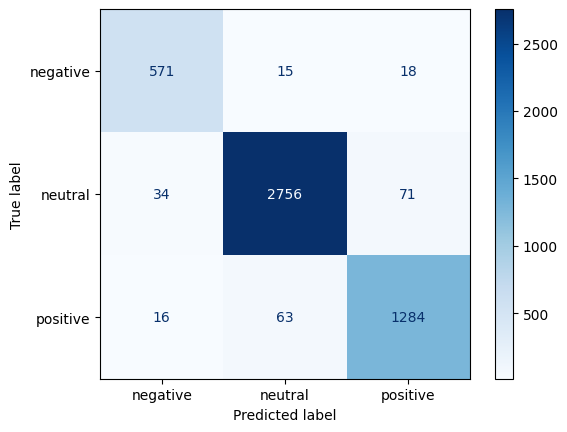

In [26]:

# Generate confusion matrix
cm = confusion_matrix(df["label"], predictions.tolist(), labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'neutral', 'positive'])

# Plot confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [27]:
!zip -r fine_tuned_model.zip /kaggle/working/fine-tuned-model

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  adding: kaggle/working/fine-tuned-model/ (stored 0%)
  adding: kaggle/working/fine-tuned-model/model.safetensors (deflated 8%)
  adding: kaggle/working/fine-tuned-model/tokenizer.json (deflated 71%)
  adding: kaggle/working/fine-tuned-model/config.json (deflated 50%)
  adding: kaggle/working/fine-tuned-model/special_tokens_map.json (deflated 80%)
  adding: kaggle/working/fine-tuned-model/tokenizer_config.json (deflated 74%)
  adding: kaggle/working/fine-tuned-model/vocab.txt (deflated 53%)
